In [1]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_rank_variable_bounds
from fastfusion.mapper.metrics import Metrics

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)
spec.mapper_ffm.metrics = Metrics.LATENCY | Metrics.ENERGY # | Metrics.RESOURCE_USAGE | Metrics.LATENCY
spec.mapper_ffm.max_loops_minus_ranks = 4
dram = spec.architecture.nodes["MainMemory"]
# dram.constraints.tensors.keep = "All()"

# spec.mapper_ffm.timeloop_style_even = True
spec.calculate_component_energy_area(area=False)
def filter_lambda(pm):
    return len(set(len(x.loops) for x in pm.compatibility.tensors if x.resource_name != "MainMemory")) <= 1
pmappings = make_pmappings(spec)

# from IPython.display import SVG
# display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()dsx

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



WARNING Loading configuration file from /root/.config/fastfusion/config.yaml
Generating tensor order and loop choices for Einsum Matmul1: 12it [00:00, 135.34it/s]
Generating tensor order and loop choices for Einsum Matmul2: 24it [00:00, 165.54it/s]
Generating tensor order and loop choices for Einsum Matmul4: 24it [00:00, 172.55it/s]
Generating tensor order and loop choices for Einsum Matmul7: 12it [00:00, 118.21it/s]

Generated 12 jobs for Matmul1
Generated 24 jobs for Matmul2


Generating tensor order and loop choices for Einsum Matmul5: 24it [00:00, 157.42it/s]
Generating tensor order and loop choices for Einsum Matmul8: 12it [00:00, 120.89it/s]
Generating tensor order and loop choices for Einsum Matmul3: 24it [00:00, 134.77it/s]
Generating tensor order and loop choices for Einsum Matmul7: 24it [00:00, 145.34it/s]
Generating tensor order and loop choices for Einsum Matmul6: 24it [00:00, 150.91it/s]
Generating jobs: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
WARNING Insufficient jobs available to utilize available threads. Splitting jobs into smaller chunks.


Generated 24 jobs for Matmul3
Generated 24 jobs for Matmul4
Generated 24 jobs for Matmul5
Generated 24 jobs for Matmul6
Generated 24 jobs for Matmul7
Generated 12 jobs for Matmul8
W5
T0
T3
T6
W6
T4
T2
W3
W4
W1
T5
W7
T7
W8
T8
W2
T1


Generating pmappings: 100%|██████████| 168/168 [00:08<00:00, 19.06it/s]


In [2]:
import fastfusion.util as util
util.PARALLELIZE = False
mappings = join_pmappings(spec, pmappings)

Compressing pmappings: 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


SIM Matmul1 tensors: {'T1'}
SIM Matmul2 tensors: {'T2', 'T1'}
SIM Matmul3 tensors: {'T3', 'T2'}
SIM Matmul4 tensors: {'T4', 'T3'}
SIM Matmul5 tensors: {'T5', 'T4'}
SIM Matmul6 tensors: {'T5', 'T6'}
SIM Matmul7 tensors: {'T6', 'T7'}
SIM Matmul8 tensors: {'T7'}


Grouping Partial Mappings for Matmul8 (8/8): 100%|██████████| 65/65 [00:00<00:00, 1301.10it/s]


Initial consolidate and group: 2.42 seconds

Einsum Matmul2 (2/8)


Merging mappings Matmul1 <--> Matmul2:  23%|██▎       | 53/233 [00:00<00:00, 523.45it/s]

Pmapping merging: 0.65 seconds
	Combining 97(57) x 104(67) -> 233
	Number of groups for Einsum Matmul2: 233
	Number of mappings for Einsum Matmul2: 233
	Mappings per group for Einsum Matmul2: 1.0
	Largest left: 1
	Largest right: 1

Einsum Matmul3 (3/8)


Merging mappings Matmul1 <--> Matmul2: 100%|██████████| 233/233 [00:00<00:00, 1189.32it/s]


Pmapping merging: 0.20 seconds
	Combining 112(65) x 119(75) -> 249
	Number of groups for Einsum Matmul3: 249
	Number of mappings for Einsum Matmul3: 249
	Mappings per group for Einsum Matmul3: 1.0
	Largest left: 1
	Largest right: 1

Einsum Matmul4 (4/8)


Merging mappings Matmul3 <--> Matmul4:  61%|██████    | 141/233 [00:00<00:00, 1280.68it/s]

Pmapping merging: 0.19 seconds
	Combining 112(65) x 119(75) -> 233
	Number of groups for Einsum Matmul4: 233
	Number of mappings for Einsum Matmul4: 233
	Mappings per group for Einsum Matmul4: 1.0
	Largest left: 1
	Largest right: 1

Einsum Matmul5 (5/8)


Merging mappings Matmul3 <--> Matmul4: 100%|██████████| 233/233 [00:00<00:00, 1264.75it/s]


Pmapping merging: 0.19 seconds
	Combining 97(57) x 104(67) -> 217
	Number of groups for Einsum Matmul5: 217
	Number of mappings for Einsum Matmul5: 217
	Mappings per group for Einsum Matmul5: 1.0
	Largest left: 1
	Largest right: 1

Einsum Matmul6 (6/8)


Merging mappings Matmul5 <--> Matmul6:  39%|███▉      | 91/233 [00:00<00:00, 848.64it/s]

Pmapping merging: 0.22 seconds
	Combining 97(57) x 104(67) -> 233
	Number of groups for Einsum Matmul6: 233
	Number of mappings for Einsum Matmul6: 233
	Mappings per group for Einsum Matmul6: 1.0
	Largest left: 1
	Largest right: 1

Einsum Matmul7 (7/8)


Merging mappings Matmul5 <--> Matmul6: 100%|██████████| 233/233 [00:00<00:00, 1088.31it/s]


Pmapping merging: 0.22 seconds
	Combining 112(65) x 119(75) -> 249
	Number of groups for Einsum Matmul7: 249
	Number of mappings for Einsum Matmul7: 249
	Mappings per group for Einsum Matmul7: 1.0
	Largest left: 1
	Largest right: 1

Einsum Matmul8 (8/8)


Merging mappings Matmul6 <--> Matmul7: 100%|██████████| 249/249 [00:00<00:00, 1164.30it/s]


Pmapping merging: 0.11 seconds
	Combining 112(65) x 112(65) -> 65
	Number of groups for Einsum Matmul8: 65
	Number of mappings for Einsum Matmul8: 65
	Mappings per group for Einsum Matmul8: 1.0
	Largest left: 1
	Largest right: 1


Merging mappings Matmul7 <--> Matmul8: 100%|██████████| 65/65 [00:02<00:00, 29.50it/s]


======== Total time ========
Initial consolidate and group: 2.42 seconds
Pmapping merging: 1.79 seconds

Total: 4.21 seconds



In [3]:
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_num_computes
for c in sorted(mappings.data.columns):
    print(c)
energy = mappings.data["Total\0energy"].min()

num_computes = get_num_computes(spec)

print(f"Energy: {energy}")
print(f"Num computes: {num_computes}")

Matmul1 energy GlobalBuffer read
Matmul1 energy GlobalBuffer write
Matmul1 energy MAC compute
Matmul1 energy MainMemory read
Matmul1 energy MainMemory write
Matmul1 latency GlobalBuffer
Matmul1 latency MainMemory
Matmul1 latency compute
Matmul1 mapping
Matmul1 tile_shape 0
Matmul1 tile_shape 1
Matmul1 tile_shape 2
Matmul1 tile_shape 3
Matmul1 tile_shape 4
Matmul1 tile_shape 5
Matmul1 tile_shape 6
Matmul2 energy GlobalBuffer read
Matmul2 energy GlobalBuffer write
Matmul2 energy MAC compute
Matmul2 energy MainMemory read
Matmul2 energy MainMemory write
Matmul2 latency GlobalBuffer
Matmul2 latency MainMemory
Matmul2 latency compute
Matmul2 mapping
Matmul2 tile_shape 0
Matmul2 tile_shape 1
Matmul2 tile_shape 2
Matmul2 tile_shape 3
Matmul2 tile_shape 4
Matmul2 tile_shape 5
Matmul2 tile_shape 6
Matmul3 energy GlobalBuffer read
Matmul3 energy GlobalBuffer write
Matmul3 energy MAC compute
Matmul3 energy MainMemory read
Matmul3 energy MainMemory write
Matmul3 latency GlobalBuffer
Matmul3 latenc

Matmul1 GlobalBuffer read
Matmul1 GlobalBuffer write
Matmul1 MainMemory read
Matmul1 MainMemory write
Matmul1 MAC compute
Matmul2 GlobalBuffer read
Matmul2 GlobalBuffer write
Matmul2 MainMemory read
Matmul2 MainMemory write
Matmul2 MAC compute
Matmul3 GlobalBuffer read
Matmul3 GlobalBuffer write
Matmul3 MainMemory read
Matmul3 MainMemory write
Matmul3 MAC compute
Matmul4 GlobalBuffer read
Matmul4 GlobalBuffer write
Matmul4 MainMemory read
Matmul4 MainMemory write
Matmul4 MAC compute
Matmul5 GlobalBuffer read
Matmul5 GlobalBuffer write
Matmul5 MainMemory read
Matmul5 MainMemory write
Matmul5 MAC compute
Matmul6 GlobalBuffer read
Matmul6 GlobalBuffer write
Matmul6 MainMemory read
Matmul6 MainMemory write
Matmul6 MAC compute
Matmul7 GlobalBuffer read
Matmul7 GlobalBuffer write
Matmul7 MainMemory read
Matmul7 MainMemory write
Matmul7 MAC compute
Matmul8 GlobalBuffer read
Matmul8 GlobalBuffer write
Matmul8 MainMemory read
Matmul8 MainMemory write
Matmul8 MAC compute
{'GlobalBuffer': [0], 'M

TypeError: only length-1 arrays can be converted to Python scalars

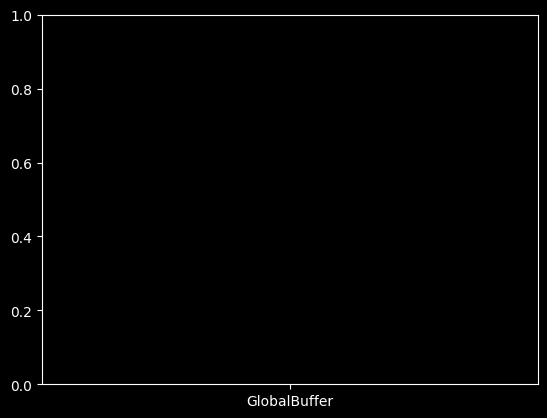

In [ ]:
matmul3 = mappings[0].access("energy").drop("Total")
for c in matmul3.columns:
    print(c)
matmul3.sum(keep_key_index=1).columns

import matplotlib.pyplot as plt

results = matmul3.sum(keep_key_index=1).to_dict()
print(results)
plt.bar(results.keys(), results.values())
plt.show()

In [5]:
from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_rank_variable_bounds_for_all_einsums

i = 0
rank_variable_bounds = get_rank_variable_bounds_for_all_einsums(spec)
mapping = make_mapping(mappings.data.iloc[i], einsum_names=spec.workload.einsum_names, rank_variable_bounds=rank_variable_bounds)
from IPython.display import SVG
display(SVG(mapping.render()))

for col in mappings.data.columns:
    print(f"{col}: {mappings.data.iloc[i][col]}")
    
# metric_Latency: 659328.583713355
# metric_Energy: 0.061079611244544

# metric_Latency: 1445760.583713355
# metric_Energy: 0.044033207435264


# Minimum latency: 396288.0
# Minimum energy: 0.043587645472768
# Minimum latency: 134745088.0
# Minimum energy: 0.043559639056384
# Minimum latency: 396288.0
# Minimum energy: 0.043599728214016004


print(f'Minimum latency: {mappings.data["Total_Latency"].min()}')
print(f'Minimum energy: {mappings.data["Total_Energy"].min()}')

IndexError: pop from empty list

In [ ]:
assert False
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
assert False
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} Pareto-optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
import importlib
import fastfusion.visualization.interactive
importlib.reload(fastfusion.visualization.interactive)
from fastfusion.visualization.interactive import plotly_show
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_rank_variable_bounds_for_all_einsums
for mappings in result.values():
    mappings.make_pareto(columns=["RESOURCE_GlobalBuffer_LEVEL_0", "Total_Energy"])
result2 = {k: v.data for k, v in result.items()}
# plotly_show(result2, "RESOURCE_GlobalBuffer_LEVEL_0", "Total_Energy", category="Category", logscales=True, einsum_names=spec.workload.einsum_names, rank_variable_bounds=get_rank_variable_bounds_for_all_einsums(spec))
plotly_show(result2, "Total_Energy", "Total_Energy", category="Category", logscales=True, einsum_names=spec.workload.einsum_names, rank_variable_bounds=get_rank_variable_bounds_for_all_einsums(spec))

# from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
# from IPython.display import SVG
# newmapping = make_mapping(mappings.data.iloc[0], spec.workload.einsum_names, get_rank_variable_bounds_for_all_einsums(spec))
# display(SVG(newmapping.render()))

In [ ]:
from IPython.display import SVG

from fastfusion.mapper.FFM.pareto import row2pmappings
# importlib.reload(fastfusion.visualization.interactive)
# importlib.reload(fastfusion.frontend.mapping)
from fastfusion.frontend.mapping import Mapping, Fill, Reservation
from fastfusion.mapper.FFM.pareto.df_convention import MAPPING_COLUMN

row = mappings.data.iloc[-1]
pmappings = row2pmappings(row, spec.workload.einsum_names, get_rank_variable_bounds_for_all_einsums(spec))
    
newmapping = Mapping.from_pmappings(pmappings, rank_variable_bounds=get_rank_variable_bounds_for_all_einsums(spec)).clear_nodes_of_type(Fill)
display(SVG(newmapping.render()))

# display(SVG(mappings.data.iloc[-1][MAPPING_COLUMN].render()))